## 개요

이 보고서는 X_ray 사진을 보고 폐렴 환자를 구분해내는 딥러닝 모델의 정확도를 올리기 위한 프로젝트입니다.  
대략 80% 정도의 정확도를 가지고 있는 폐렴 진단 모델의 정확도를 최대한 올리는 게 목적입니다.  
  
<br />

---  

<br />

## 목차

### 1. 데이터 준비

##### 데이터 로딩 및 전처리
- X-ray 이미지 데이터는 학습(train), 검증(validation), 테스트(test)로 분리.
- 데이터 경로:
 - 학습 데이터: /train/*/*
 - 검증 데이터: /val/*/*
 - 테스트 데이터: /test/*/*

<br />   

##### 라벨 정의
- 이미지 파일의 경로를 이용해 라벨 정의 (get_label 함수):
  - PNEUMONIA 경로는 양성(True).
  - NORMAL 경로는 음성(False).

<br />

##### 데이터 전처리
- 이미지 전처리 작업 (decode_img 함수):
  - JPEG 형식 이미지를 float32로 변환.
  - 크기를 [180, 180]으로 리사이즈.

##### 데이터셋 생성
- 파일 경로 리스트를 tf.data.Dataset으로 변환 (from_tensor_slices 사용).
- 데이터를 랜덤하게 섞고, 배치(batch)로 묶음:
```python
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
```
- 데이터 증강 적용 (augment 함수):
  - 좌우 및 상하 반전, 밝기 조정, 대비 조정 등을 수행.

<br />

---

### 2. 모델 정의

##### 기존 모델 구조

- ResNet-18 구조를 기반으로 Residual Block 사용:
  - ResNet은 Residual Connection을 통해 정보 손실을 최소화.
  - Residual Block 구현 :
      ```python
  class ResidualBlock(tf.keras.Model):
      def __init__(self, filters, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, 3, strides=stride, padding='same', activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters, 3, strides=1, padding='same', activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.downsample = None
  ```

<br />

##### ResNet-18 모델 정의
- ResNet-18 모델 구조 구현 :
  ```python
  def build_resnet18():
    inputs = tf.keras.layers.Input(shape=(180, 180, 3))
    x = tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(128, stride=2)(x)
    x = ResidualBlock(256, stride=2)(x)
    x = ResidualBlock(512, stride=2)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs, outputs)

  ```

<br />

---

### 3. 모델 학습

##### Loss 및 Optimizer

- 손실 함수 : Binary Crossentropy
- Optimizer : Adam (학습률 1e-r)사용.

##### Class Weight 설정
- 데이터 불균형 문제를 해결하기 위해 클래스 가중치 적용 :
  ```python
    weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
    weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0
    class_weight = {0: weight_for_0, 1: weight_for_1}
  ```

<br />

##### 훈련
- 학습 및 검증 데이터를 사용해 모델 훈련 :
  ```python
    with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

  ```

### 4. 결과 시각화

##### 정확도 및 손실 그래프
- 학습 및 검증 정확도 / 손실 시각화 :
  ```python
    def plot_history(history):
      acc = history.history['accuracy']
      val_acc = history.history['val_accuracy']
      loss = history.history['loss']
      val_loss = history.history['val_loss']

      plt.figure(figsize=(8, 8))
      plt.subplot(2, 1, 1)
      plt.plot(acc, label='Training Accuracy')
      plt.plot(val_acc, label='Validation Accuracy')
      plt.legend(loc='lower right')
      plt.ylabel('Accuracy')

      plt.subplot(2, 1, 2)
      plt.plot(loss, label='Training Loss')
      plt.plot(val_loss, label='Validation Loss')
      plt.legend(loc='upper right')
      plt.ylabel('Loss')
      plt.xlabel('epoch')
      plt.show()

    plot_history(history)

  ```

---

<br />

## 요약 및 회고

- 현재 모델의 성능:
  - 초기 정확도: 약 80%.
  - ResNet-18 도입 후 성능: 약 **83%**로 향상.
- 개선 방안:
  - 추가 데이터 증강 기법 도입.
  - Learning Rate 스케줄링 적용.
  - 더 깊은 ResNet 구조로 확장(ResNet-34, ResNet-50).

<br />

---

<br />

## 참고사항

- 코랩에서 테스트를 반복하다가 GPU 환경 무료 사용량이 초과되서 CPU로 테스트 하는 과정이 너무 오래 걸려 시간 내에 프로젝트 제출이 어려울 것 같아 동일한  코드로 LMS의 클라우드 환경에서 테스트 후 나온 결과를 따로 첨부합니다.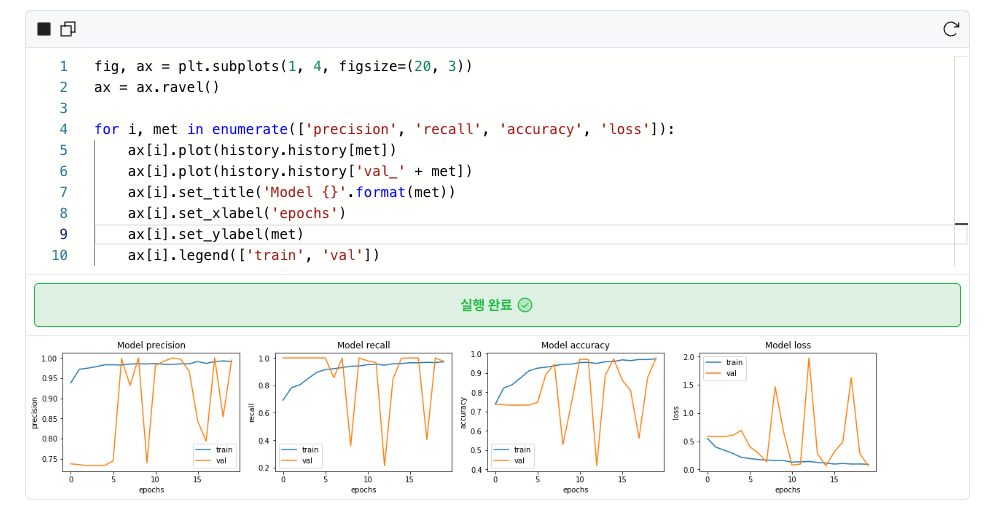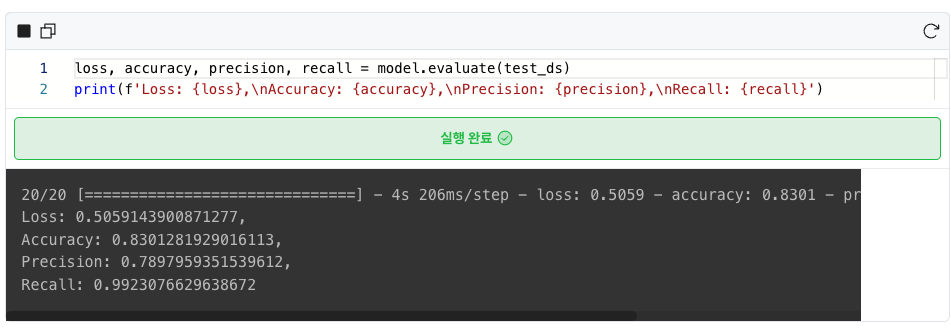
